x_train : (1179, 5)
y_train : (1179,)
x_test : (295, 5)
y_test : (295,)


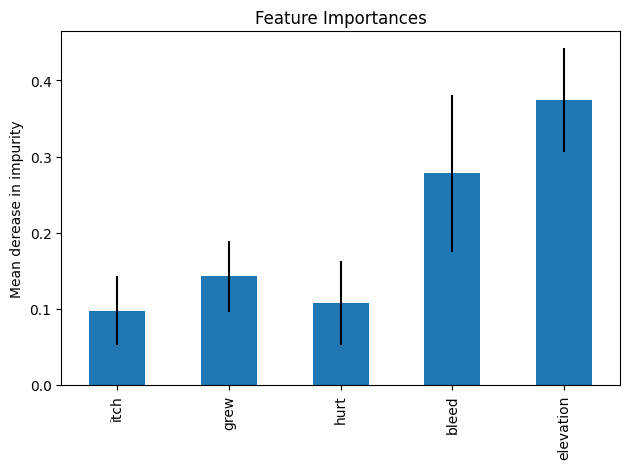

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r"C:\Users\anna-\OneDrive\Desktop\ITU\2nd semester\Projects in Data Science\Project\df.csv") #change this path!!

y = df['diagnostic'].copy() #column with verdict: cancer or not cancer
best_features = ['itch','grew','hurt','bleed','elevation']
#best_features = 
x = df[best_features]

#Deviding into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=101) #stratify = y makes sure that both training and test sets preserve the original class proportions.

#This gives us:
#80% training (x_train)
#20% test (x_test)

print(f'x_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_test : {y_test.shape}')

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

importances=rf_model.feature_importances_
std=np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index= best_features)
fig, ax= plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel('Mean derease in impurity')
fig.tight_layout()
# print('Plot of Random Forest without finetuning (originally it had all features and we selected top 5 to proceed to finetuning)')
# feat_importances = pd.Series(rf_model.feature_importances_, index=x.columns)
# feat_importances.nlargest(20).plot(kind='barh')
# plt.title("Feature Importances")
# plt.show()


In [4]:
param_grid = [{
    'n_estimators':[100,200,500], #More trees = better performance up to a point, then diminishing returns.
    'max_depth': [3, 5, 10, 20], #higher the values the more we risk overfitting
    'criterion': ['entropy', 'gini'], #can also comment this out
    'min_samples_split': [5,10,15], # minimum number of samples a node must have to be split into two child nodes in a decision tree. Default is 2 (canm overfit)
    'min_samples_leaf': [1, 2, 4]#,
    #'max_features': ['sqrt', 'log2', None]

}]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
grid_search = GridSearchCV(rf_model,
                           param_grid,
                           cv=skf, #this splits testing data to test and validation based on cancer/non-cancer proportions (so they have same percentage of cancer)
                                    #if we use this, we dont have to split training data ourselves at the beginning
                           scoring = 'recall',
                           n_jobs=-1,                          
                           )

grid_search.fit(x_train, y_train)

print(f'Grid search best score: {grid_search.best_score_}')
print(f'Grid search best parameters: {grid_search.best_params_}')

#Training the rf with what criteria recomended by grid search (= best parameters)
best_params = grid_search.best_params_

c:\Users\anna-\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Grid search best score: 0.9368801313628901
Grid search best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


Train Report:
              precision    recall  f1-score   support

           0       0.67      0.37      0.47       308
           1       0.81      0.94      0.87       871

    accuracy                           0.79      1179
   macro avg       0.74      0.65      0.67      1179
weighted avg       0.77      0.79      0.76      1179

Confusion Matrix:
 [[113 195]
 [ 55 816]]

Test Report:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        77
           1       0.80      0.89      0.85       218

    accuracy                           0.76       295
   macro avg       0.68      0.64      0.65       295
weighted avg       0.74      0.76      0.74       295

Confusion Matrix:
 [[ 29  48]
 [ 23 195]]


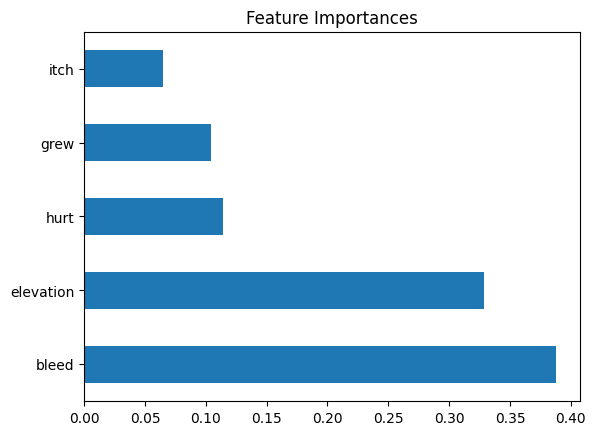

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [11]:
rf_final = RandomForestClassifier(**best_params, random_state=101) #if we want to increase recall for 0 (lower false positive), add here: class_weight='balanced'
rf_final.fit(x_train, y_train)

#Evaluating on training and test set
y_pred = rf_final.predict(x_train)
print("Train Report:")
print(classification_report(y_train, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

y_test_pred = rf_final.predict(x_test)
print("\nTest Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

feat_importances = pd.Series(rf_final.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importances")
plt.show()

# top performing features = bleed, elevation, hurt, grew, itch, smoke, changed, pesticide, cancer_history, skin_cancer history

print(best_params)

In [ ]:
#If we wanted to change the recall for healthy people, we could adjust the threshold for classifying something as cancer - but it didnt make much difference in this model (1 percent better recall on 0)
probs_val = rf_final.predict_proba(x_train)[:, 1]

thresholds = np.arange(0.3, 0.91, 0.05)

print("Threshold\tRecall_0\tRecall_1\tTotal_Accuracy")
print("-" * 50)

best_thresh = 0.5
best_recall_1 = 0
best_report = ""

for thresh in thresholds:
    preds = (probs_val >= thresh).astype(int)
    recall_0 = recall_score(y_train, preds, pos_label=0)
    recall_1 = recall_score(y_train, preds, pos_label=1)
    accuracy = (preds == y_train).mean()
    
    print(f"{thresh:.2f}\t\t{recall_0:.2f}\t\t{recall_1:.2f}\t\t{accuracy:.2f}")

Threshold	Recall_0	Recall_1	Total_Accuracy
--------------------------------------------------
0.30		0.00		1.00		0.74
0.35		0.00		1.00		0.74
0.40		0.00		1.00		0.74
0.45		0.24		0.97		0.78
0.50		0.37		0.94		0.79
0.55		0.38		0.94		0.79
0.60		0.38		0.94		0.79
0.65		0.48		0.87		0.77
0.70		0.65		0.78		0.75
0.75		0.86		0.56		0.64
0.80		0.93		0.46		0.58
0.85		0.93		0.44		0.57
0.90		0.94		0.35		0.50


Trying a different model (including diameter)

